In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
RANDOM_SEED = 42
# if cuda is available, use cuda
device = "cuda" if torch.cuda.is_available() else "cpu"

<AxesSubplot: >

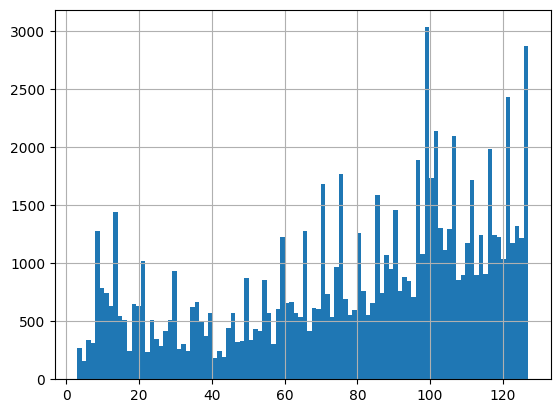

In [3]:
df = pd.read_csv("archive/2018-06-06-ss.cleaned.csv")

df = df[df["seq"].str.contains("[*]") == False]
maxlen_seq = 128

df = df.loc[df["seq"].str.len() < maxlen_seq]


In [4]:
def n_grams(seqs, n=3):
    """
    seqs: list of sequences
    n: length of n-grams
    return: list of n-grams

    example:
    seqs = ['ABC', 'DEF']
    n = 2
    return = [['AB', 'BC', 'C'], ['DE', 'EF', 'F']]
    """
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs], object)

In [5]:
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T

In [7]:
x = n_grams(input_seqs)

In [9]:
path_encoder = ("./tolkenizer_encoder.json")
path_decoder = ("./tolkenizer_decoder.json")

"""
making tokenizer for encoder and decoder

the encoder will be used to encode the input sequence
the decoder will be used to encode the target sequence

the decoder will be used to decode the output of the model

both saved as json files for later use
"""
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(x)
input_data = tokenizer_encoder.texts_to_sequences(x)
input_data = pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)

tokenizer_encoder_json = tokenizer_encoder.to_json()
with open(path_encoder, 'w', encoding='utf-8') as f:
    f.write(tokenizer_encoder_json)
    
tokenizer_decoder_json = tokenizer_decoder.to_json()
with open(path_decoder, 'w', encoding='utf-8') as f:
    f.write(tokenizer_decoder_json)

In [10]:
reverse_decoder_index = {value: key for key, value in tokenizer_decoder.word_index.items()}    
reverse_decoder_index

{1: 'c', 2: 'h', 3: 'e'}

In [11]:
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1

8421 4


In [12]:
class LSTM(nn.Module):
    """
    LSTM model for sequence tagging
    """

    def __init__(self, n_words,, n_tags, hidden_size=64, dropout=0.1):
        """
        :param n_words:
        :param n_tags:
        :param hidden_size:
        :param dropout:

        :type n_words: int
        :type n_tags: int
        :type hidden_size: int
        :type dropout: float
        """
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(n_words, 128, padding_idx=0)
        self.bilstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=1, 
                              batch_first=True, bidirectional=True, dropout=dropout)
        self.dense = nn.Linear(hidden_size*2, n_tags)
        
    def forward(self, x):
        return self.dense(self.bilstm(self.embedding(x))[0])

In [13]:
model = LSTM(n_words, maxlen_seq, n_tags)

C:\Users\Leagr\miniconda3\envs\mol3022\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
def q3_acc(y_true, y_pred):
    """
    calculate accuracy for the model

    :param y_true:
    :param y_pred:
    :return:
    :rtype: float
    """
    y = torch.argmax(y_true, dim=-1)
    y_ = torch.argmax(y_pred, dim=-1)
    mask = (y > 0)
    return torch.mean((y[mask] == y_[mask]).float())

In [15]:
optimizer = torch.optim.RMSprop(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [16]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)

In [17]:

seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

In [18]:
# train the model for 5 epochs
for epoch in range(5):
    running_loss = 0.0
    model.train()
    for i in tqdm(range(0, len(X_train), 128)):
        # batch size = 128
        # make tensors for inputs and targets
        inputs = torch.tensor(X_train[i:i+128]).to(device)
        targets = torch.tensor(y_train[i:i+128]).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # predict
        outputs = model(inputs)

        # calculate loss
        loss = loss_fn(outputs.view(-1, n_tags), targets.view(-1, n_tags))

        # backpropagate
        loss.backward()

        # update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Evaluate the model on the validation data
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test).to(device))
        val_loss = loss_fn(y_pred.view(-1, n_tags), torch.tensor(y_test).view(-1, n_tags)).item()
        val_acc = q3_acc(torch.tensor(y_test).to(device), y_pred)

    print('Epoch: %d | Train loss: %.4f | Val loss: %.4f | Val acc: %.4f' %
          (epoch+1, running_loss / (len(X_train) // 128), val_loss, val_acc))

  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.3195 | Val loss: 0.2530 | Val acc: 0.8453


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 2 | Train loss: 0.2099 | Val loss: 0.2277 | Val acc: 0.8640


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 3 | Train loss: 0.1819 | Val loss: 0.2088 | Val acc: 0.8768


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 4 | Train loss: 0.1676 | Val loss: 0.2121 | Val acc: 0.8772


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 5 | Train loss: 0.1597 | Val loss: 0.2019 | Val acc: 0.8827


In [19]:
#model.load_state_dict(torch.load('model_1.torch', map_location=torch.device('cpu')))

training
---
Input: TQEAFDLISKENPSSQYWKEVAEQRRKALYEALKENEKLHKEIEQKDSEIARLRKENKDLAEVAEHVQYMAEVIERLSN
Target: CCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHCCCC
Result: CCCCCCHHCCHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC


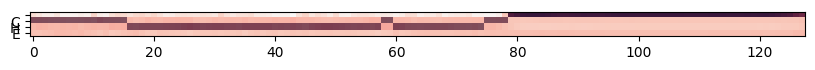

---
Input: GGTIAKVTGPSTGAVGRNIEFSGKDSKDEDGKIVSYDWDFGDGATSRGKNSVHAYKKAGTYNVTLKVTDDKGATATESFTIEIKN
Target: CCCECCCEEECEEECCCEEEEECCCCECCCCCEEEEEEECCCCCEEECCEEEEECCCCEEEEEEEEEEECCCCEEEEEEEEEEEC
Result: CCCEEEEEEECEEECCCEEEEECCCCECCCCCEEEEEEECCCCCEEECCEEEEEECCCEEEEEEEEEEECCCCEEEEEEEEEEEC


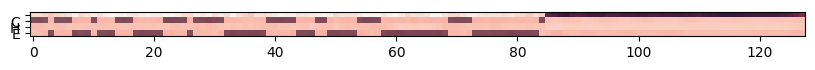

---
Input: MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM
Target: CCCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC
Result: CCCECCEEEEEECCCCCCCCCCEEEEEEEEEECCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC


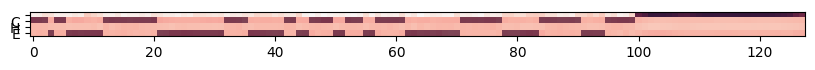

testing
---
Input: MEFQKKKQKVIQVKEIKFRPGTDEGDYQVKLRSLIRFLEEGDKAKITLRFRGREMAHQQIGMEVLNRVKDDLQELAVVESFPTKIEGRQMIMVLAPKKKQ
Target: CCCCCCCCCCCEEEEEEECCCCCHHHHCHHHHHHHHHHHCCEEEEEEECCCCCCCCCCCHHHHHHHHHHHHHCCCEEECCCCCCCCCCCCEEEEEECCCC
Result: CCCHCCCCEEEEEEEEECCCCCCCCEECHHHHHHHCHHCCCCCEEEEEEECCCHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCHCCECCCCCCCCC


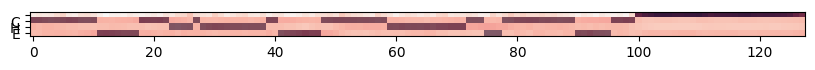

---
Input: STNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIVLMAEALEKLFLQKINELPTE
Target: CCCCCCCCCCCCCCCCCCCHHHHHHHHCHHHHHHCCCCCHHHCCCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCCCCCCCCCCCCCCCHHHHHHHHCHHHHHHCCCCCHHHCCCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHCCCCC


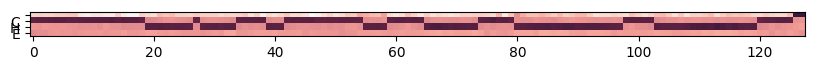

---
Input: SMSVKKPKRDDSKDLALCSMILTEMETHEDAWPFLLPVNLKLVPGYKKVIKKPMDFSTIREKLSSGQYPNLETFALDVRLVFDNCETFNEDDSDIGRAGHNMRKYFEKKWTDTFK
Target: CCCCCCCCCCCCCHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCCCCCCHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHC


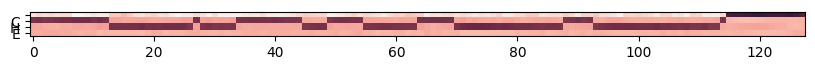

In [20]:
def onehot_to_seq(oh_seq, index):
    """
    convert one-hot encoded sequence to string
    :param oh_seq:
    :param index:
    :return:
    """
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    """
    plot the results
    :param x:
    :param y:
    :param y_:
    :return:
    """
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model(torch.tensor(X_train[:N])).detach().numpy()
y_test_pred = model(torch.tensor(X_test[:N])).detach().numpy()
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

In [21]:
torch.save(model.state_dict(), "model_1.torch")